In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr

from armored.models import *
from armored.preprocessing import *

from sklearn.model_selection import KFold

import re
import itertools

from tqdm import tqdm

colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Olive
    "#17becf",  # Teal
    "#9edae5",  # Light Blue
    "#c7c7c7",  # Light Gray
    "#c49c94",  # Light Red
    "#98df8a",  # Light Green
    "#f7b6d2"   # Light Pink
]

/home/jcthompson5@ad.wisc.edu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# import community data
df_comm = pd.read_csv("Data/arc_allcomm.csv")

# import monoculture data
df_mono = pd.read_csv("Data/arc_allmono.csv")

# define species and pH
species = ['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 
           'CC_OD', 'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD']
controls = []
metabolites = ['pH']

# concatenate all observed and all system variables 
observed = np.concatenate((np.array(species), np.array(metabolites)))
system_variables = np.concatenate((np.array(species), np.array(metabolites), np.array(controls)))
system_variables

array(['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD',
       'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD', 'pH'],
      dtype='<U32')

In [3]:
# average replicates in train set for fitting data transform
df_mono_copy = df_mono.copy()
df_mono_copy['Experiments'] = [re.split(r'(_\d+)', exp_name, maxsplit=1)[0] for exp_name in df_mono_copy.Experiments.values]
df_avg = []
for exp_name, df_exp in df_mono_copy.groupby("Experiments"):
    df_groups = df_exp.groupby("Time")
    df_avg_i = df_groups[system_variables].mean().reset_index()
    df_avg_i.insert(0, "Experiments", [exp_name]*df_avg_i.shape[0])
    df_avg.append(df_avg_i)
df_mono_avg = pd.concat(df_avg)

# average replicates in test set for fitting data transform
df_comm_copy = df_comm.copy()
df_comm_copy['Experiments'] = [re.split(r'(_\d+)', exp_name, maxsplit=1)[0] for exp_name in df_comm_copy.Experiments.values]
df_avg = []
for exp_name, df_exp in df_comm_copy.groupby("Experiments"):
    df_groups = df_exp.groupby("Time")
    df_avg_i = df_groups[system_variables].mean().reset_index()
    df_avg_i.insert(0, "Experiments", [exp_name]*df_avg_i.shape[0])
    df_avg.append(df_avg_i)
df_comm_avg = pd.concat(df_avg)

# scale data 
scaler = MinMaxScaler(observed, system_variables)

scaler.fit(df_mono_avg)
df_mono_scaled = scaler.transform(df_mono.copy())
df_comm_avg_scaled = scaler.transform(df_comm_avg.copy())

# format data into matrix [n_samples, n_timepoints, dt+n_outputs+n_controls]
data_mono_scaled = format_data(df_mono_scaled, species, metabolites, controls, observed=observed)
data_comm_avg = format_data(df_comm_avg, species, metabolites, controls, observed=observed)
data_comm_avg_scaled = format_data(df_comm_avg_scaled, species, metabolites, controls, observed=observed)

In [4]:
# instantiate model
brnn = miRNN(n_species=len(species), 
             n_metabolites=len(metabolites), 
             n_controls=len(controls), 
             n_hidden=16)

In [5]:
# fit model
brnn.fit(data_mono_scaled, alpha_0=1e-3, evd_tol=1e-3)

Total measurements: 1985, Number of parameters: 717, Initial regularization: 1.00e-03
Loss: 383.117, Residuals: -0.02223
Loss: 296.966, Residuals: -0.00382
Loss: 269.629, Residuals: -0.00601
Loss: 145.906, Residuals: -0.01649
Loss: 115.933, Residuals: -0.00204
Loss: 115.002, Residuals: -0.00424
Loss: 106.878, Residuals: -0.00354
Loss: 99.461, Residuals: -0.00184
Loss: 93.756, Residuals: -0.00186
Loss: 92.982, Residuals: 0.00014
Loss: 91.860, Residuals: 0.00007
Loss: 90.073, Residuals: 0.00011
Loss: 89.841, Residuals: -0.00030
Loss: 88.422, Residuals: 0.00114
Loss: 88.320, Residuals: 0.00042
Loss: 88.150, Residuals: 0.00041
Loss: 87.882, Residuals: 0.00038
Loss: 87.440, Residuals: 0.00051
Loss: 87.358, Residuals: 0.00011
Loss: 86.739, Residuals: 0.00029
Loss: 85.832, Residuals: 0.00052
Loss: 85.601, Residuals: 0.00012
Loss: 85.180, Residuals: 0.00012
Loss: 85.078, Residuals: 0.00010
Loss: 84.101, Residuals: 0.00033
Loss: 82.664, Residuals: 0.00060
Loss: 82.359, Residuals: 0.00004
Loss: 

In [6]:
# make predictions
predictions = scaler.inverse_transform(brnn.predict(data_comm_avg_scaled))

2024-08-19 16:50:22.726080: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


In [7]:
# save predictions
pred_df = pd.DataFrame()
for (T, X, U, Y, exp_names), (_, preds, stdvs, exp_names_pred) in zip(data_comm_avg, predictions):

    # save species predictions for each experimental condition
    for i, exp_name in enumerate(exp_names):
        # init dataframe
        pred_df_exp = pd.DataFrame()

        # insert exp name
        pred_df_exp["Experiments"] = [exp_name]*len(T[i])
        pred_df_exp["Time"] = T[i]

        for j, s in enumerate(observed):
            pred_df_exp[s + " true"] = Y[i,:,j]
            pred_df_exp[s + " pred"] = preds[i,:,j]
            pred_df_exp[s + " stdv"] = stdvs[i,:,j]

        # append to test prediction dataframe
        pred_df = pd.concat((pred_df, pred_df_exp))

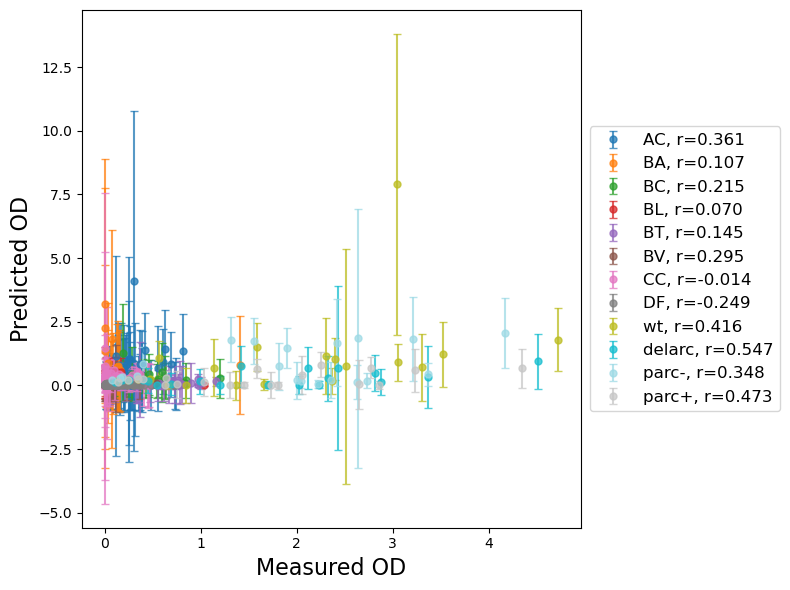

In [18]:
# import kfold results
all_true_vals = []
all_pred_vals = []

plt.figure(figsize=(8, 6))

for i, obs in enumerate(species):
    true_vals = []
    pred_vals = []
    stdv_vals = []
    
    for exp_name, kf_df in pred_df.groupby("Experiments"):
        true_vals_exp = kf_df[f'{obs} true'].values
        pred_vals_exp = kf_df[f'{obs} pred'].values 
        stdv_vals_exp = kf_df[f'{obs} stdv'].values 
        
        # if species was inoculated        
        if true_vals_exp[0] > 0:
            # if not nan
            for true_val_exp, pred_val_exp, stdv_val_exp in zip(true_vals_exp[1:], pred_vals_exp[1:], stdv_vals_exp[1:]):
                if not np.isnan(true_val_exp):
                    true_vals.append(true_val_exp)
                    pred_vals.append(pred_val_exp)
                    stdv_vals.append(stdv_val_exp)
    
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    stdv_vals = np.array(stdv_vals)
    
    R = linregress(true_vals, pred_vals).rvalue
    r_vals.append(R)
    mse_vals.append(np.mean((true_vals-pred_vals)**2))
    # nll_vals.append(np.mean((((true_vals-pred_vals)/stdv_vals)**2)/2. + np.log(stdv_vals)))
    plt.errorbar(true_vals, pred_vals, 
                 yerr=stdv_vals, label='{}, r={:.3f}'.format(obs.split("_")[0], R),
                 fmt='.', capsize=3, markersize=10, c=colors[i], alpha=.75)
    
    # append to set of all measured and predicted values
    all_true_vals.append(true_vals)
    all_pred_vals.append(pred_vals)
    
# plot
# plt.xticks([0., .4, .8, 1.2], fontsize=16)
plt.xlabel("Measured OD", fontsize=16)

# plt.yticks([0., .4, .8, 1.2], fontsize=16)
plt.ylabel("Predicted OD", fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, .5), fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
all_true_vals = np.concatenate(all_true_vals)
all_pred_vals = np.concatenate(all_pred_vals)

In [17]:
linregress(all_true_vals, all_pred_vals)

LinregressResult(slope=0.2678963163821645, intercept=0.11944519318089158, rvalue=0.3887910396754988, pvalue=7.84119690769824e-29, stderr=0.023058401711499033, intercept_stderr=0.016692296036569364)

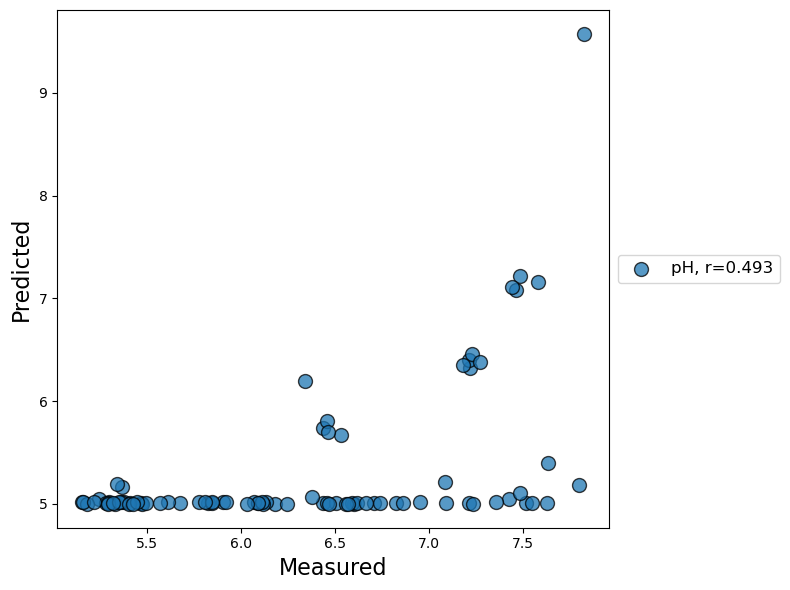

In [9]:
# import kfold results
r_vals = []
mse_vals = []
nll_vals = []

for i, obs in enumerate(metabolites):
    plt.figure(figsize=(8, 6))
    
    true_vals = []
    pred_vals = []
    stdv_vals = []
    
    for exp_name, kf_df in pred_df.groupby("Experiments"):
        true_vals_exp = kf_df[f'{obs} true'].values
        pred_vals_exp = kf_df[f'{obs} pred'].values 
        stdv_vals_exp = kf_df[f'{obs} stdv'].values 
        
        # if not nan      
        for true_val_exp, pred_val_exp, stdv_val_exp in zip(true_vals_exp[1:], pred_vals_exp[1:], stdv_vals_exp[1:]):
            if not np.isnan(true_val_exp):
                true_vals.append(true_val_exp)
                pred_vals.append(pred_val_exp)
                stdv_vals.append(stdv_val_exp)
    
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    stdv_vals = np.array(stdv_vals)
    
    R = linregress(true_vals, pred_vals).rvalue
    r_vals.append(R)
    mse_vals.append(np.mean((true_vals-pred_vals)**2))
    # nll_vals.append(np.mean((((true_vals-pred_vals)/stdv_vals)**2)/2. + np.log(stdv_vals)))
    '''plt.errorbar(true_vals, pred_vals, 
                 yerr=stdv_vals, label='{}, r={:.3f}'.format(obs[:2], R),
                 fmt='.', capsize=3, markersize=10, c=colors[i], alpha=.75)'''
    plt.scatter(true_vals, pred_vals, label='{}, r={:.3f}'.format(obs, R),
                s=100, edgecolor='k', c=colors[i], alpha=.75)
    
    # plot
    # plt.xticks([0., .4, .8, 1.2], fontsize=16)
    plt.xlabel("Measured", fontsize=16)

    # plt.yticks([0., .4, .8, 1.2], fontsize=16)
    plt.ylabel("Predicted", fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, .5), fontsize=12)
    plt.tight_layout()
    plt.show()